In [ ]:
!pip install pm4py
!pip install optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=f7f350925cfef6bac90b9d5f1e1fdb79e1a238ee5ddc8370d855f5b5c8af6f00
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
log_url = "https://data.4tu.nl/datasets/6a0a26d2-82d0-4018-b1cd-89afb0e8627f"

In [ ]:
import pm4py
import optuna
import pandas as pd
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristic_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.check_soundness import check_easy_soundness_net_in_fin_marking
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.statistics.traces.generic.pandas import case_statistics

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


**Choose dataset**

In [15]:
# Domestic declarations log
log = pm4py.read_xes('DomesticDeclarations.xes')

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [ ]:
# # Italian helpdesk log
# data = pd.read_csv('finale.csv')
# data.rename(columns={
#     'Case ID': 'case:concept:name',
#     'Activity': 'concept:name',
#     'Complete Timestamp': 'time:timestamp'
# }, inplace=True)

# # Convert the timestamp column to datetime format
# data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])

# # Ensure the activity names are treated as strings
# data['concept:name'] = data['concept:name'].astype(str)
# log = data

In [16]:
log

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
...,...,...,...,...,...,...,...,...,...,...
56432,st_step 138363_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-12-29 17:50:14,EMPLOYEE,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56433,st_step 138361_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-12-29 17:56:13,ADMINISTRATION,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56434,st_step 138362_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2019-01-03 08:55:52,SUPERVISOR,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56435,dd_declaration 138359_19,SYSTEM,Request Payment,2019-01-08 08:20:28,UNDEFINED,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576


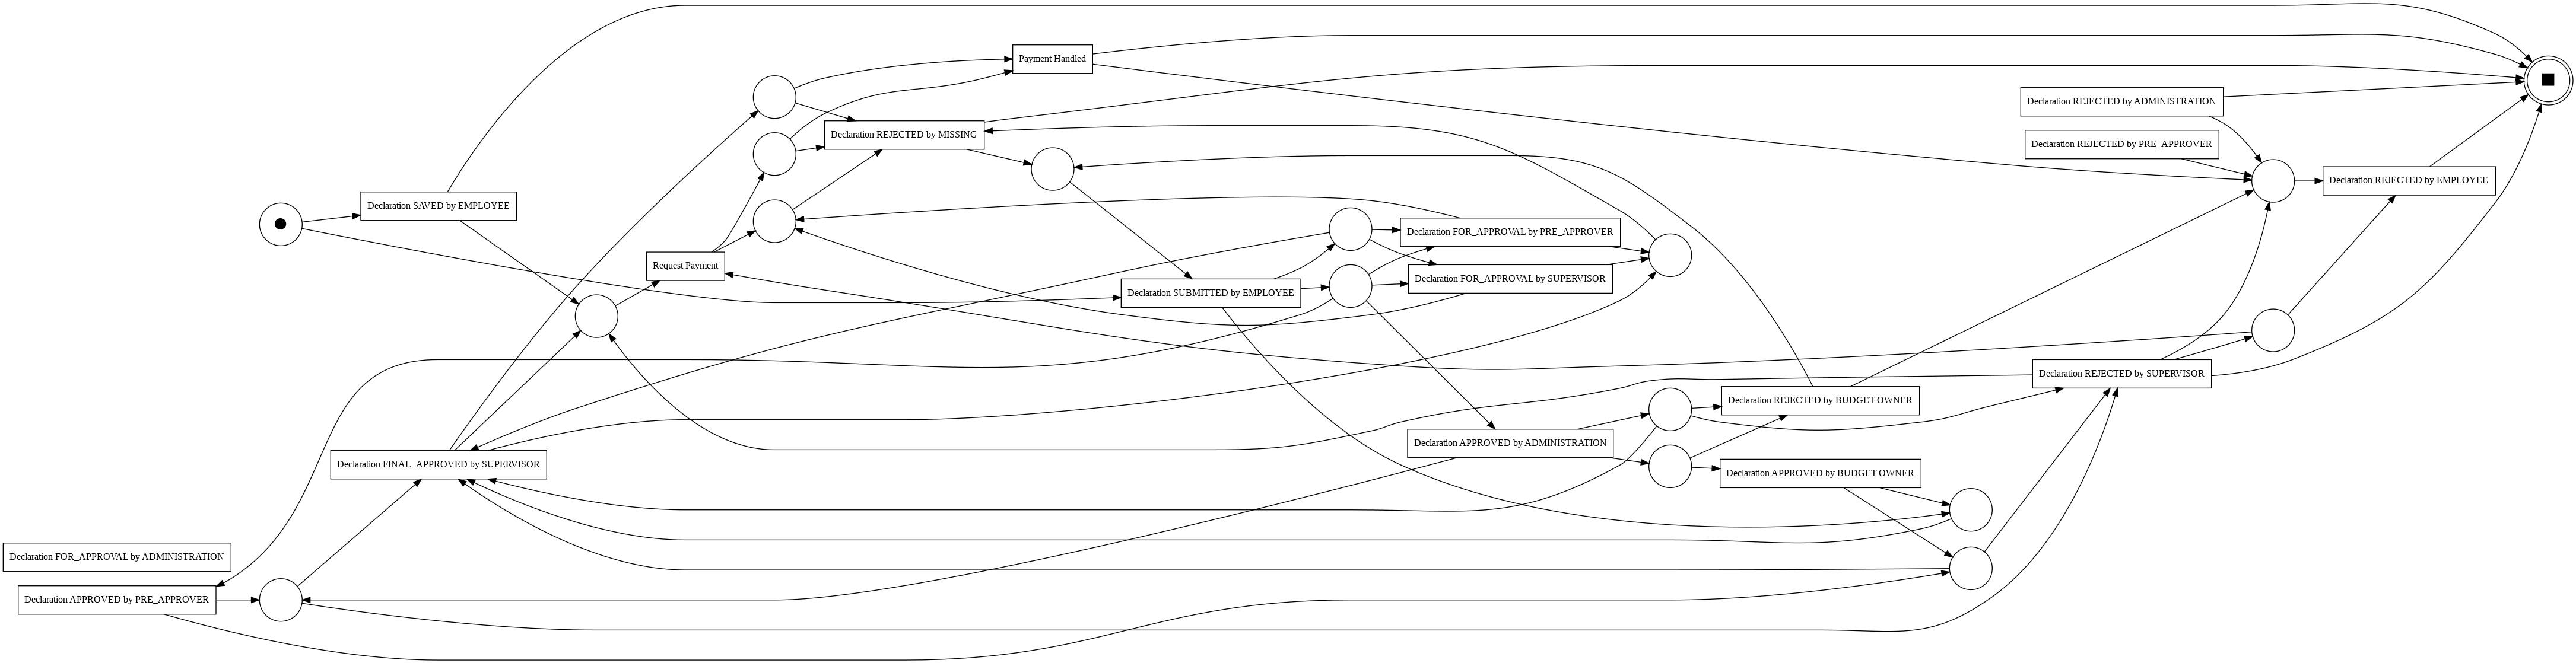

In [17]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

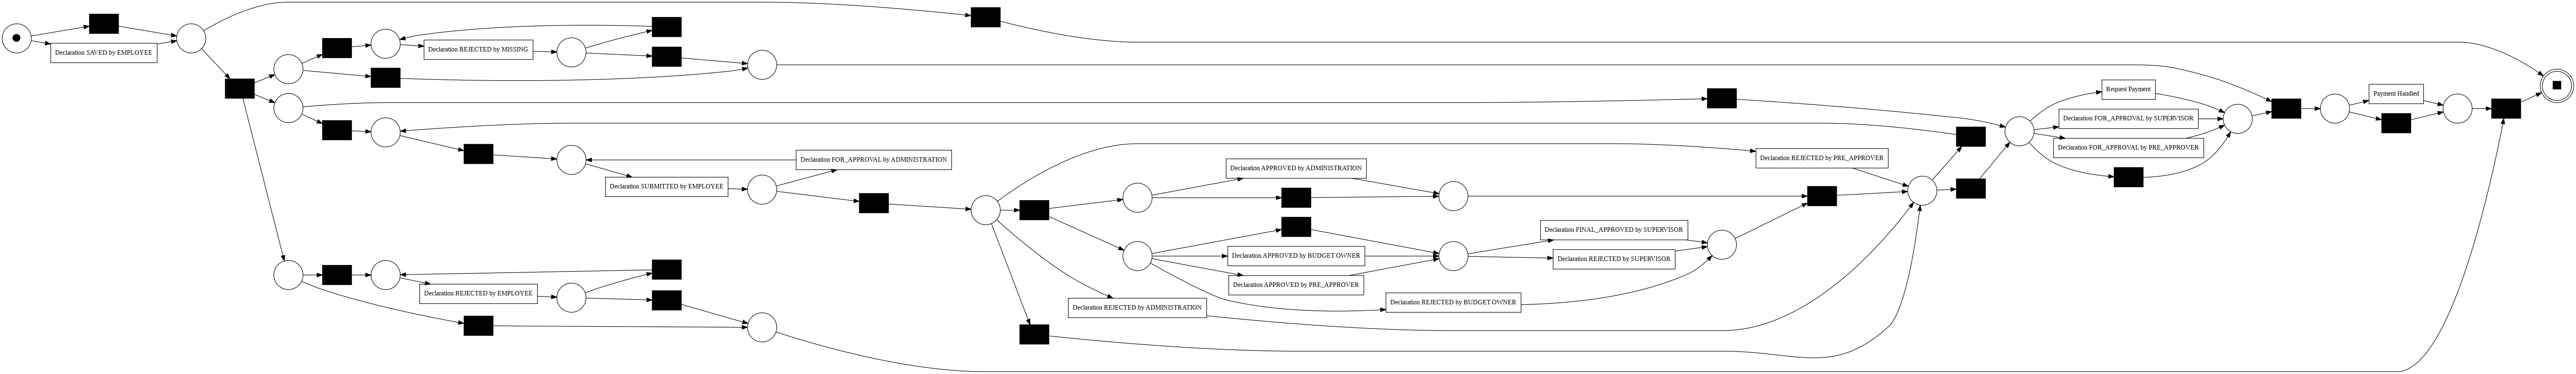

In [18]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

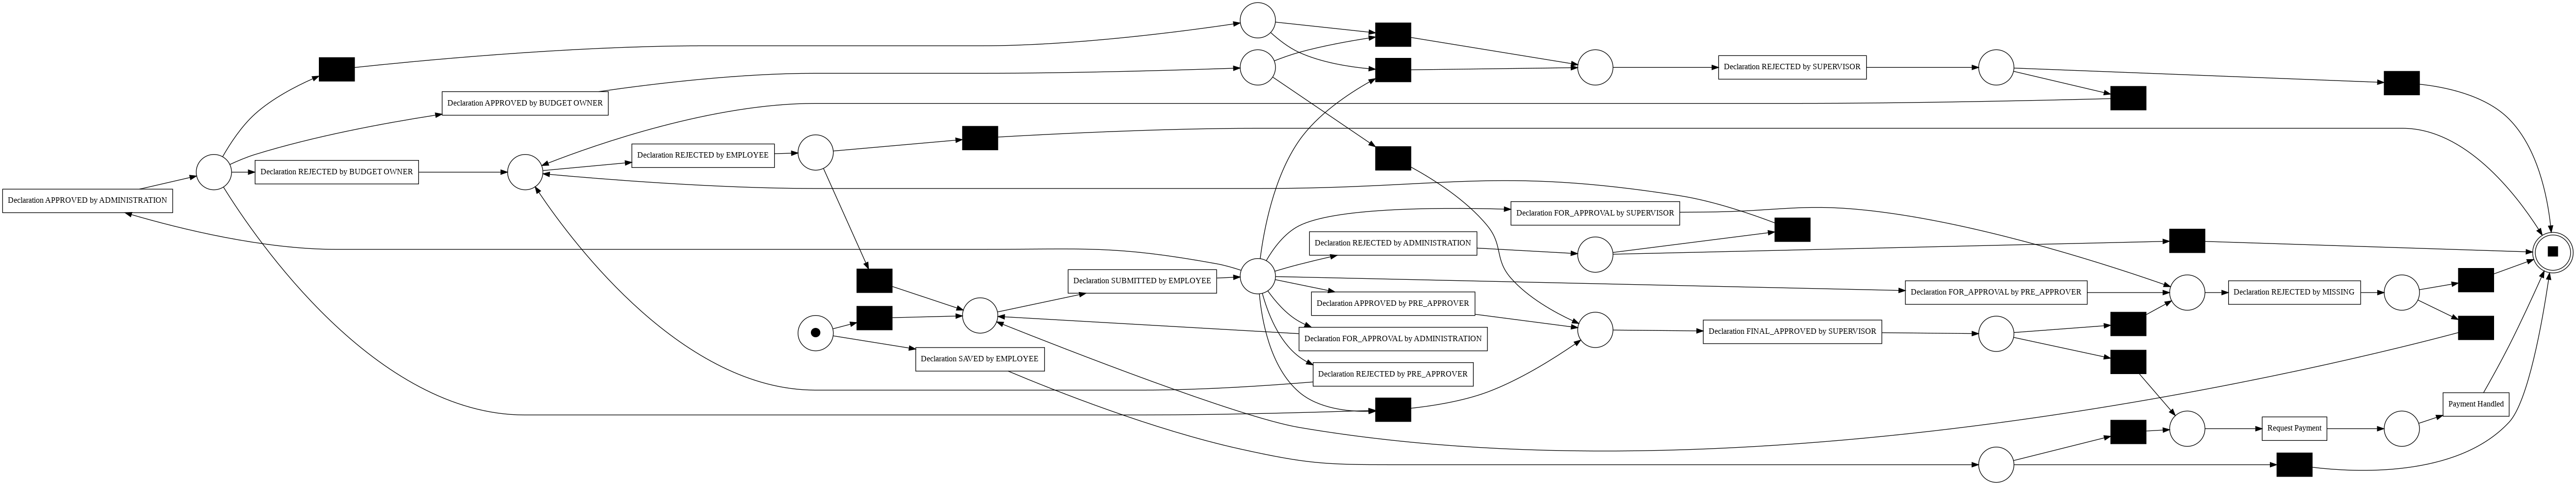

In [19]:
net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

In [20]:
"""
Functions for evaluation
"""

def evaluate_fitness(net, initial_marking, final_marking, log):
    # Check if the produced net has sound structure or not
    is_sound = check_easy_soundness_net_in_fin_marking(net, initial_marking, final_marking)

    if is_sound:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.ALIGNMENT_BASED
        )
    else:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.TOKEN_BASED
        )

    return fitness_results["log_fitness"]

def evaluate_simplicity(net, weight_places=1, weight_transitions=2, weight_arcs=1):
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)

    # Calculate complexity
    complexity = (
        weight_places * num_places +
        weight_transitions * num_transitions +
        weight_arcs * num_arcs
    )
    simplicity = 1 / (complexity + 1)  # Get inverse, +1 is for non-zero division
    return simplicity

def evaluate_generalization(net, initial_marking, final_marking, log):
    # Trace coverage
    replay_results = token_replay.apply(log, net, initial_marking, final_marking)
    fully_replayed = sum(1 for res in replay_results if res['trace_is_fit'])
    trace_coverage = fully_replayed / len(replay_results) if replay_results else 0

    # Model complexity vs. log variability
    unique_traces = case_statistics.get_variant_statistics(log)
    num_unique_traces = len(unique_traces)
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)
    model_complexity = num_places + num_transitions + num_arcs
    variability_ratio = num_unique_traces / (model_complexity + 1)
    # Final score
    generalization = (trace_coverage * 0.6) + (variability_ratio * 0.4)
    return generalization

In [21]:
def apply_alpha(log):
    net, initial_marking, final_marking = alpha_miner.apply(log)
    return net, initial_marking, final_marking

def apply_heuristic(log, parameters):
    net, initial_marking, final_marking = heuristic_miner.apply(log, parameters=parameters)
    return net, initial_marking, final_marking

def apply_inductive(log, noise_threshold=0.0):
    parameters = {"noise_threshold": noise_threshold}
    process_tree = inductive_miner.apply(log, parameters=parameters)
    # inductive returns process tree which needs to be converted to petri-net
    net, initial_marking, final_marking = pt_converter.apply(process_tree)
    return net, initial_marking, final_marking

In [22]:
def objective(trial):
    # algorithm selection
    algorithm = trial.suggest_categorical("algorithm", ["alpha", "heuristic", "inductive"])
    if algorithm == "alpha":
        net, initial_marking, final_marking = apply_alpha(log)
    elif algorithm == "heuristic":
        dependency_thresh = trial.suggest_float("dependency_thresh", 0.0, 1.0)
        and_measure_thresh = trial.suggest_float("and_measure_thresh", 0.5, 1.0)
        loop_two_thresh = trial.suggest_float("loop_two_thresh", 0.0, 1.0)
        parameters = {
        "dependency_thresh": dependency_thresh,
        "and_measure_thresh": and_measure_thresh,
        "loop_two_thresh": loop_two_thresh
        }
        net, initial_marking, final_marking = apply_heuristic(log, parameters=parameters)
    elif algorithm == "inductive":
        noise_threshold = trial.suggest_float("noise_threshold", 0.0, 0.3)
        net, initial_marking, final_marking = apply_inductive(log, noise_threshold=noise_threshold)

    # evaluation metrics
    fitness = evaluate_fitness(net, initial_marking, final_marking, log)
    simplicity = evaluate_simplicity(net)
    generalization = evaluate_generalization(net, initial_marking, final_marking, log)
    combined_score = fitness * 0.6 + simplicity * 0.2 + generalization * 0.2

    return combined_score

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-12-15 21:20:36,280] A new study created in memory with name: no-name-404ccbad-bc11-42eb-a7f7-1b20dca69c17


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:20:39,974] Trial 0 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.1756739822032577, 'and_measure_thresh': 0.6265188108619707, 'loop_two_thresh': 0.0951703428496018}. Best is trial 0 with value: 0.6397636257043636.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:20:44,449] Trial 1 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.18326504551497946, 'and_measure_thresh': 0.5714925278090819, 'loop_two_thresh': 0.13970309988387009}. Best is trial 0 with value: 0.6397636257043636.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:20:46,667] Trial 2 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.6397636257043636.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:20:51,690] Trial 3 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2598783869411492}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:20:57,745] Trial 4 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.17721423660509877}. Best is trial 3 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:20:59,938] Trial 5 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:03,282] Trial 6 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.12773801619836256, 'and_measure_thresh': 0.8441919347410693, 'loop_two_thresh': 0.9693258021169262}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:08,615] Trial 7 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.05774593732849759}. Best is trial 3 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:11,453] Trial 8 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 3 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:13,645] Trial 9 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:18,455] Trial 10 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.29249135777873947}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:24,390] Trial 11 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.23433004396475224}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:29,138] Trial 12 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.18463696113831093}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:33,917] Trial 13 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.10040719664849054}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:39,987] Trial 14 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.17602179052989406}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:44,817] Trial 15 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.27004765887790755}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:50,613] Trial 16 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.22335797682371034}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:21:55,616] Trial 17 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1174261363653443}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:00,477] Trial 18 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.22068617133579066}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:04,662] Trial 19 finished with value: 0.6726239136966062 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9825490792233749, 'and_measure_thresh': 0.9853221143452636, 'loop_two_thresh': 0.8266729962599927}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:09,609] Trial 20 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1415321396483065}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:15,086] Trial 21 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.018405019663503365}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:20,722] Trial 22 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.06916801292029195}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:25,535] Trial 23 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.029817339929887637}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:31,707] Trial 24 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.0595708134612116}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:36,592] Trial 25 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.17675680638617247}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:41,555] Trial 26 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2566824296554137}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:47,344] Trial 27 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1304863332589536}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:50,438] Trial 28 finished with value: 0.6585010590953313 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.78744552027239, 'and_measure_thresh': 0.7681382217419042, 'loop_two_thresh': 0.5240534909405485}. Best is trial 3 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:52,674] Trial 29 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:22:56,160] Trial 30 finished with value: 0.6954003397734909 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.5146910157274175, 'and_measure_thresh': 0.5000864418193078, 'loop_two_thresh': 0.4667520051374119}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:01,737] Trial 31 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2967905095778196}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:06,663] Trial 32 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2900522693244461}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:12,853] Trial 33 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2556225098674301}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:17,814] Trial 34 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.20461040970916303}. Best is trial 3 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:20,106] Trial 35 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:23,672] Trial 36 finished with value: 0.6585010590953313 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.5695770548687689, 'and_measure_thresh': 0.9684621148480648, 'loop_two_thresh': 0.47026589791645823}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:29,432] Trial 37 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.09012610475099155}. Best is trial 3 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:31,668] Trial 38 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:36,927] Trial 39 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.27360614124365285}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:42,862] Trial 40 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.16030501368294198}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:47,920] Trial 41 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2303196408901877}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:54,450] Trial 42 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2429182221970642}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:23:59,366] Trial 43 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.27818330736300034}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:24:04,360] Trial 44 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.19435998489679754}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:24:10,821] Trial 45 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2498406159537212}. Best is trial 3 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:24:12,930] Trial 46 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:24:18,347] Trial 47 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.20868902811044984}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:24:22,591] Trial 48 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.38187406180963457, 'and_measure_thresh': 0.6879549378070808, 'loop_two_thresh': 0.6764026948414298}. Best is trial 3 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 21:24:27,452] Trial 49 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.29626596862441873}. Best is trial 3 with value: 0.7697161312897309.


Best algorithm and parameters:
{'algorithm': 'inductive', 'noise_threshold': 0.2598783869411492}


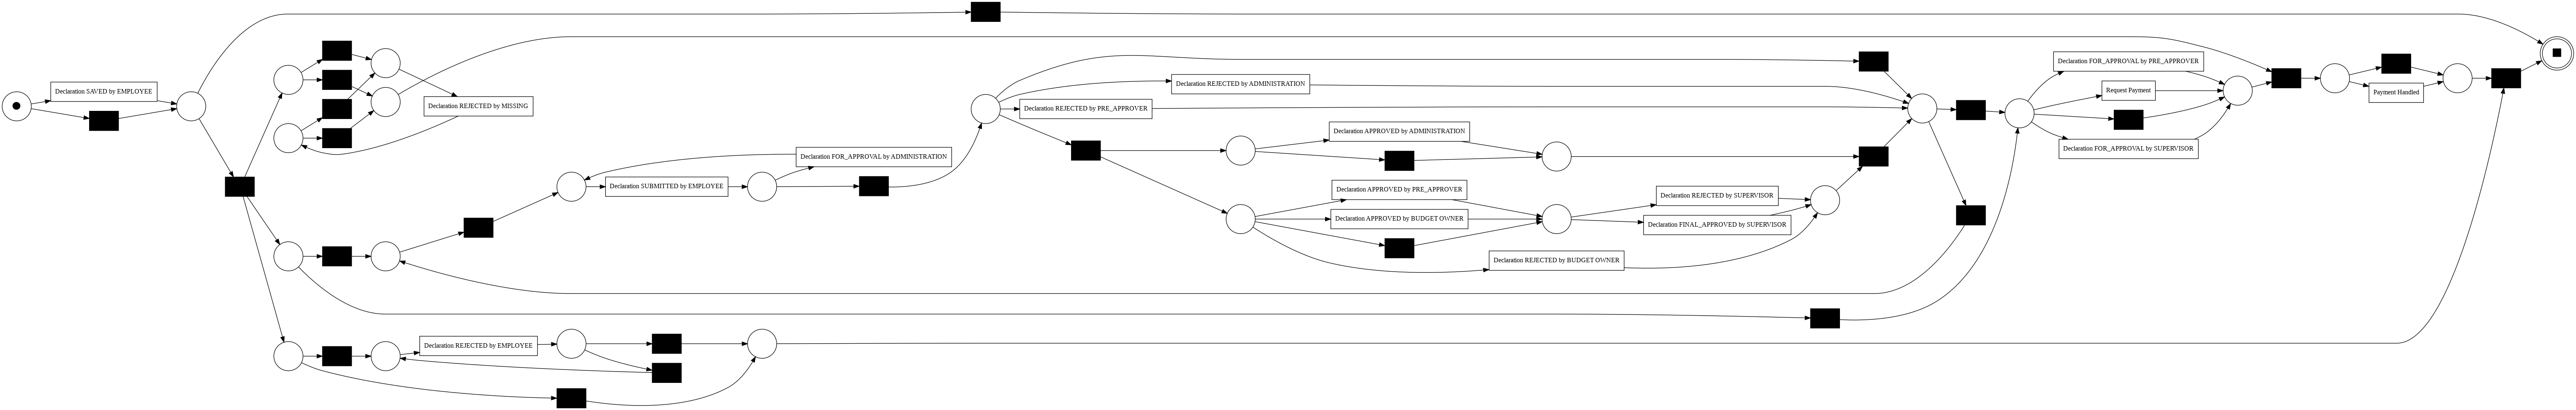

In [24]:
print("Best algorithm and parameters:")
print(study.best_params)

# Apply the best model to get the final process model
best_algorithm = study.best_params["algorithm"]
if best_algorithm == "alpha":
    final_net, final_initial_marking, final_final_marking = apply_alpha(log)
elif best_algorithm == "heuristic":
    best_dependency_thresh = study.best_params["dependency_thresh"]
    final_net, final_initial_marking, final_final_marking = apply_heuristic(log, dependency_thresh=best_dependency_thresh)
elif best_algorithm == "inductive":
    best_noise_threshold = study.best_params["noise_threshold"]
    final_net, final_initial_marking, final_final_marking = apply_inductive(log, noise_threshold=best_noise_threshold)

# Visualize the best model
gviz = pn_visualizer.apply(final_net, final_initial_marking, final_final_marking)
pn_visualizer.view(gviz)

In [35]:
# prompt: what are the goodness of different outcomes of optuna output in "study"

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print("    {}: {}".format(key, value))

print("  System attrs:")
for key, value in trial.system_attrs.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value:  0.7697161312897309
  Params: 
    algorithm: inductive
    noise_threshold: 0.2598783869411492
  User attrs:
  System attrs:


In [37]:
# prompt: what are the parameters tried in "study". make a pandas table. reorder columns in # prompt: what are the parameters tried in "study". make a pandas table.
# import pandas as pd
# # Create a list to store the trial parameters
# trials_data = []
# # Iterate through the trials and extract the parameters
# for trial in study.trials:
#     trial_data = trial.params.copy()  # Start with the parameters
#     trial_data['value'] = trial.value  # Add the objective value
#     trials_data.append(trial_data)
# # Create the Pandas DataFrame
# trials_df = pd.DataFrame(trials_data)
# trials_df to make value last column

import pandas as pd

# Create a list to store the trial parameters
trials_data = []
# Iterate through the trials and extract the parameters
for trial in study.trials:
    trial_data = trial.params.copy()  # Start with the parameters
    trial_data['value'] = trial.value  # Add the objective value
    trials_data.append(trial_data)
# Create the Pandas DataFrame
trials_df = pd.DataFrame(trials_data)

#Move value column to the last
cols = list(trials_df.columns)
cols.remove('value')
cols.append('value')
trials_df = trials_df[cols]

trials_df

,algorithm,dependency_thresh,and_measure_thresh,loop_two_thresh,noise_threshold,value
0,heuristic,0.175674,0.626519,0.095170,NaN,0.639764
1,heuristic,0.183265,0.571493,0.139703,NaN,0.639764
2,alpha,NaN,NaN,NaN,NaN,0.514729
3,inductive,NaN,NaN,NaN,0.259878,0.769716
4,inductive,NaN,NaN,NaN,0.177214,0.769716
5,alpha,NaN,NaN,NaN,NaN,0.514729
6,heuristic,0.127738,0.844192,0.969326,NaN,0.639764
7,inductive,NaN,NaN,NaN,0.057746,0.769716
8,alpha,NaN,NaN,NaN,NaN,0.514729
9,alpha,NaN,NaN,NaN,NaN,0.514729


In [39]:
# see how many different values are there in trials_df
algorithm_counts = trials_df['value'].value_counts()
algorithm_counts

,count
value,
0.769716,34
0.514729,8
0.639764,4
0.658501,2
0.672624,1
0.695400,1


In [40]:
# see how many different values are there in trials_df with inductive algorithm
trials_df[(trials_df.algorithm=="inductive")]['value'].value_counts()

,count
value,
0.769716,34


In [45]:
trials_df[["algorithm", "value"]].groupby("algorithm").count()

,value
algorithm,
alpha,8
heuristic,8
inductive,34
